# T-Maze

Experiments with modifications to the t-maze enviroment.

see https://papers.nips.cc/paper/1953-reinforcement-learning-with-long-short-term-memory.pdf

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import sys

import csv
import os

import random
import matplotlib.pyplot as plt
import numpy as np

from multiprocessing import Pool
import queue
import time

In [2]:
class TMaze:   
    
    def __init__(self, size=3, step_reward=0.0):
        self.size = size #takes size number of steps to reach decision node
        self.step_reward = step_reward
    
    def __str__(self):
        statement = "Position: {}, Size: {}, Goal: {} ".format(self.position, self.size, self.getGoal(self.goal)) 
        return statement
                
    def getGoal(self, num):
        if num == 1:
            return "E"
        else:
            return "W"
        
    def max_score(self):
        """ returns the maximum possiable score on this enviroment. """
        return 4.0 + self.step_reward * self.size
        
    def step(self, action):
        """
        action - [0,1,2,3]
        directions = ["N","S","E","W"]
        Returns observation and reward
        """
        dx,dy = self.getDis(action)
        
        reward = self.step_reward
        done = False
        
        self.position += dy
        
        #going beyond maze upwards
        if self.position > self.size:
            reward = -0.1
            self.position += -1
        #downwards
        elif self.position < 0:
            reward = -0.1
            self.position += 1
            
        #moving left or right    
        if dx != 0:
            if self.position == self.size:
                if dx == self.goal:
                    reward = 4
                else:
                    reward = -0.1
                self.reset()
                done = True
            else:
                reward = -0.1
        
        return self.getObs(self.position),reward, done    
            
        
    def getObs(self, position):
        if position == 0:
            return self.observations[0]
        elif position == self.size:
            return self.observations[2]
        else:
            return self.observations[1]
    
    def getDis(self, action):
        """
        returns dx and dy, that represent change in position 
        """
        dis = [(0,1), (0,-1), (1,0), (-1,0)]
        return dis[action]
    
    def getAction(self, action):
        """
        for abstraction
        """
        directions = ["N","S","E","W"]
        return directions[action]
    
    def reset(self):
        
        """ Resets and returns initial observation """
        self.position = 0
        goal = random.choice([1,-1])
        self.goal = goal # 1 = 'E' -1 = 'W'        
        #'110' is W ;011 is E, corridor, decision node
        if goal == 1:
            self.observations = [(0,1,1),(1,0,1), (0,1,0)]
        else:
            self.observations = [(1,1,0),(1,0,1), (0,1,0)]
        return self.getObs(0)
    

In [3]:
env = TMaze() #size 3
print(env.reset())

print(env)

print(env.step(1))
print(env.step(2))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(2))

(0, 1, 1)
Position: 0, Size: 3, Goal: E 
((0, 1, 1), -0.1, False)
((0, 1, 1), -0.1, False)
((1, 0, 1), 0.0, False)
((1, 0, 1), 0.0, False)
((0, 1, 0), 0.0, False)
((0, 1, 0), -0.1, False)
((1, 1, 0), 4, True)


In [4]:
print(env)

Position: 0, Size: 3, Goal: W 


In [5]:
class RandomAgent():
    
    def __init__(self):
        pass
    
    def act(self, obs,reward, done):
        return random.choice([0,1,2,3])

In [6]:
randAgent = RandomAgent()
env = TMaze()
obs = env.reset()

done = False
reward = 0
totalRewards = []
episodes = 100
totalSteps = []
for i in range(episodes):
    cumReward = 0
    for step in range(1000):
        action = randAgent.act(obs,reward, done)
        obs,reward,done = env.step(action)
        cumReward += reward

        if done:
            break
    totalSteps.append(step)
    totalRewards.append(cumReward)
    #print("CumReward: {}, Steps: {}, Episode: {} ".format(cumReward, step, i)) 


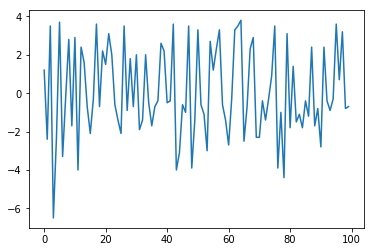

In [7]:
plt.plot(range(episodes), totalRewards)
plt.show()

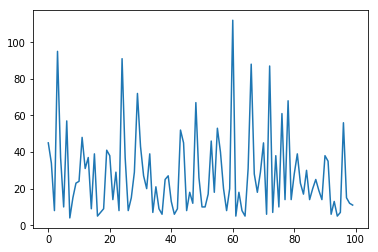

In [8]:
plt.plot(range(episodes), totalSteps)
plt.show()

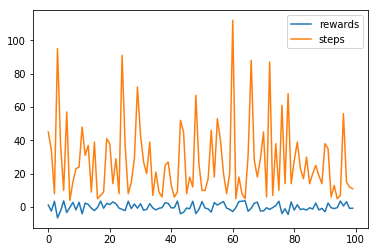

In [9]:
plt.plot(range(episodes), totalRewards, label = "rewards")
plt.plot(range(episodes), totalSteps, label = 'steps')
plt.legend()
plt.show()

# LSTM Agent as per 

https://arxiv.org/pdf/1507.06527.pdf
    

In [10]:
# Our Fast / Slow model
class LSTM_Agent(nn.Module):
    
    def __init__(self, input_dims = 3, hidden_dims = 12, memory_dims = 3, actions_dims = 4, learning_rate = 0.001, epsilon=0.1):
        
        super().__init__()
        
        self.memory_dims = memory_dims
        self.actions_dims = actions_dims
        
        self.hidden = nn.Linear(input_dims, hidden_dims)
        
        self.lstm = nn.LSTM(hidden_dims, memory_dims)
        
        self.q = nn.Linear(memory_dims, actions_dims)
                
        self.optimizer = optim.Adam(self.parameters(), learning_rate)
        
        self.epsilon = epsilon
        
        self.reset()
                
    def reset(self):
        # dims are sequence length, batch_size, number of units.
        self.h_state = torch.zeros(1, 1, self.memory_dims)
        self.c_state = torch.zeros(1, 1, self.memory_dims)
        
    def forward(self, x):
                
        h = F.relu(self.hidden(x))        
        # lstm expects dims 1,1,3 i.e. sequence_length, batch_size, memory units
        h = h.unsqueeze(0)
        memory_activations, (self.h_state, self.c_state) = self.lstm(h, (self.h_state, self.c_state))
        q_out = self.q(memory_activations)
        
        return q_out
    
    def act(self, observation, e_greedy=True):
        """ Returns an action based on current policy, and q values """
        
        observation = torch.FloatTensor(observation).to('cpu')
        observation = observation.unsqueeze(0) # make into dims (1,3)
        q = self(observation).squeeze() # remove the 1 dims.
        
        if e_greedy and np.random.rand() < self.epsilon:
            # pick random action
            return int(random.choice(range(self.actions_dims))), q
        else:
            # pick optimal            
            return int(np.argmax(q.detach())), q
        
class LSTM_Passthru_Agent(nn.Module):
 
    def __init__(self, input_dims = 3, hidden_dims = 12, memory_dims = 3, actions_dims = 4, learning_rate = 0.001, epsilon=0.1):
        
        super().__init__()
        
        self.memory_dims = memory_dims
        self.actions_dims = actions_dims
        
        self.hidden = nn.Linear(input_dims, hidden_dims)                
        self.lstm = nn.LSTM(hidden_dims, memory_dims)
        
        self.q = nn.Linear(memory_dims + hidden_dims, actions_dims)
                
        self.optimizer = optim.Adam(self.parameters(), learning_rate)
        
        self.epsilon = epsilon
        
        self.reset()
                
    def reset(self):
        # dims are sequence length, batch_size, number of units.
        self.h_state = torch.zeros(1, 1, self.memory_dims)
        self.c_state = torch.zeros(1, 1, self.memory_dims)
        
    def forward(self, x_in):
                            
        h = F.relu(self.hidden(x_in))        
        
        # lstm expects dims 1,1,3 i.e. sequence_length, batch_size, memory units
        memory_in = h.unsqueeze(0)        
        memory_activations, (self.h_state, self.c_state) = self.lstm(memory_in, (self.h_state, self.c_state))
        
        memory_activations = memory_activations.squeeze(0)        
        
        concat = torch.cat([memory_activations, h], dim=1)
        
        q_out = self.q(concat)
        
        return q_out
    
    def act(self, observation, e_greedy=True):
        """ Returns an action based on current policy, and q values """
        
        observation = torch.FloatTensor(observation).to('cpu')
        observation = observation.unsqueeze(0) # make into dims (1,3)
        q = self(observation).squeeze() # remove the 1 dims.
        
        if e_greedy and np.random.rand() < self.epsilon:
            # pick random action
            return int(random.choice(range(self.actions_dims))), q
        else:
            # pick optimal            
            return int(np.argmax(q.detach())), q
    

class LSTM_Smart_Agent(LSTM_Agent):
    
    """ This agent can only perform 'valid' actions, which simplifies the learning task to just
        remembering the initial pattern.
    """
    
    def __init__(self, can_go_north_at_end=False, **kwargs):
        super().__init__(**kwargs)
        self.can_go_north_at_end = can_go_north_at_end
    
    
    def act(self, observation, e_greedy=True):
        """ Returns action based on current policy and q values, but
            excludes invalid actions.
        """
        
        observation = torch.FloatTensor(observation).to('cpu')
        observation = observation.unsqueeze(0) # make into dims (1,3)
        q = self(observation).squeeze() # remove the 1 dims.
        
        
        if np.array_equal(np.array(observation[0]), np.array([0,1,0])):
            valid_actions = [0,2,3] if self.can_go_north_at_end else [2,3]
        else:
            valid_actions = [0]
        
        if e_greedy and np.random.rand() < self.epsilon:
            # pick random action
            return int(random.choice(valid_actions)), q
        else:
            # pick optimal            
            q_values_for_valid_actions = [q.detach()[action] for action in valid_actions]
            optimal_valid_action = np.argmax(q_values_for_valid_actions)
            return valid_actions[optimal_valid_action], q

    

In [11]:
# Hyper Parameters
GAMMA = 0.98
EPSILON = 0.10
LEARNING_RATE = 0.0003

PRINT_EVERY = 1000

In [12]:
def eval_agent(agent, env, trials=100, verbose=False, use_egreedy=False):
    """ Evaulates agent by running it greed through a number of trials.
        Returns average reward.
    """
        
    observation = env.reset()

    done = False
    reward = 0
    totalRewards = []
    totalSteps = []

    for i in range(trials):    
        cumReward = 0

        # clear agents memory
        agent.reset()

        observation = env.reset()

        # get first action for agent
        action, q_values = agent.act(observation, e_greedy=use_egreedy)    

        max_steps = 250

        agent.optimizer.zero_grad()

        for step in range(max_steps):

            # get next action and state

            next_observation, reward, done = env.step(action)
            next_action, next_q_values = agent.act(next_observation, e_greedy=use_egreedy)            

            # ------------------------------
            # calculate DQN Loss        

            # v is the estimated value of the next state 
            v = torch.max(next_q_values)

            # q is the estimated value of the current state / action pair
            q = q_values[action]  
            
            if verbose:
                print("step: {} action: {} q: {}, obs: {}, pos: {} ".format(step,next_action, np.array(next_q_values.detach()), next_observation, env.position))
            
            # keep track of everything
            cumReward += reward

            observation = next_observation
            action = next_action
            q_values = next_q_values        

            if done:
                break            

        totalSteps.append(step)
        totalRewards.append(cumReward)
        
    return np.mean(totalRewards)

def run_test(depth, agent, verbose=False, stepReward=0.0):

    global totalRewards
    global totalSteps
    global scoreHistory
            
    env = TMaze(depth, step_reward=stepReward)

    observation = env.reset()

    done = False
    reward = 0
    totalRewards = []
    totalSteps = []
    scoreHistory = []
    episodes = 200000
    
    did_reach_optimal = -1
    
    for i in range(episodes):    
        cumReward = 0

        # clear agents memory
        agent.reset()

        observation = env.reset()

        # get first action for agent
        action, q_values = agent.act(observation)    

        max_steps = 250
        
        if did_reach_optimal >= 0 and i >= did_reach_optimal + 5000:
            return did_reach_optimal
            

        if i % 10000 == 0 and i != 0 and not verbose:
            print(".",end='')
            sys.stdout.flush() # makes the prints happen immediately
            
        if i % PRINT_EVERY == 0 and i != 0:
            
            av_reward = np.mean(totalRewards[-1000:])
            score = eval_agent(agent, env)
            
            if verbose:
                print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}, eps:{:.3f} score:{:.3f}".format(
                    i, 
                    av_reward,
                    np.mean(totalSteps[-1000:]),
                    EPSILON,
                    score))
                
            scoreHistory.append((i, score))
            
            if did_reach_optimal == -1 and score >= env.max_score() * 0.95:
                # we give the agent a little grace,
                # also, eval turns off e-greedy.
                # as far as I can tell the agent should converge to 4.0
                did_reach_optimal = i

        loss = 0

        agent.optimizer.zero_grad()

        for step in range(max_steps):

            # get next action and state

            next_observation, reward, done = env.step(action)
            next_action, next_q_values = agent.act(next_observation)            

            # ------------------------------
            # calculate DQN Loss        

            # v is the estimated value of the next state 
            v = torch.max(next_q_values)

            # q is the estimated value of the current state / action pair
            q = q_values[action]  
            loss += (reward + GAMMA * v - q)**2     

            # keep track of everything
            cumReward += reward

            observation = next_observation
            action = next_action
            q_values = next_q_values        

            if done:
                break            

        # apply update
        loss.backward()
        agent.optimizer.step()

        #EPSILON = EPSILON * (1-1/1000)

        totalSteps.append(step)
        totalRewards.append(cumReward)
    
    print("Did not converge.")
    
    print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}, eps:{:.3f}".format(
                    i, 
                    np.mean(totalRewards[-1000:]),
                    np.mean(totalSteps[-1000:]),
                    EPSILON
    ))
    return -1
    

In [16]:
def smooth(X, gamma = 0.9):
    """ Returns exponential moving average. """
    y = np.mean(X[:500])
    out = []
    for x in X:
        y = gamma * y + (1-gamma) * x
        out.append(y)
    return out

def generateResults(depth_start=0, depth_end=5, agent_type = 'original', step_reward=0.0, continuous_learning=False):
    """
    prints results/graphs and stores results in csv
    
    @param depth_start starting depth of maze
    @param depth_end ending depth of maze (depths will be increased in steps of 5)
    @param agent_type type of agent, 'original' or 'passthru'
    @param step_reward reward / penality at each step
    @param continuous_learning if agent parameters should be reset at end of maze
    
    CSV Files - Organised into directories Agent_NegReward\depth_i\file 
    file is of three types - rewards.csv, results.csv, scores.csv
    Agent - 'original' or 'passthru'
    NegReward - negative step reward or 0 step reward
    depth_i where i is the depth number of the TMaze
    """
    
    def get_agent():    
        if agent_type.lower() == 'original':
            return LSTM_Agent(learning_rate=LEARNING_RATE, epsilon=EPSILON)
        elif agent_type.lower() == 'passthru':
            return LSTM_Passthru_Agent(learning_rate=LEARNING_RATE, epsilon=EPSILON)
        else:
            raise exception("Invalid parameter agent_type={}".format(agent_type))

    
    results = []
    
    job_name = "depth_start={} depth_end={} agent_type={}, step_reward={} continuous_learning={}".format(
            depth_start, depth_end, agent_type, step_reward, continuous_learning
            )
    
    short_job_name = "{}-{} {} {} {}".format(
            depth_start, depth_end, agent_type, step_reward, continuous_learning
            )
    
    path = "results/{}/".format(job_name)
        
    # if folder already exists with a results file skip this job as it is already done.
    if os.path.exists(os.path.join(path, "done.txt")):
        print("Skipping {}.".format(path))
        return        

    agent = get_agent()
    
    for depth in range(depth_start,depth_end+1,5):

        if not continuous_learning:
            agent = get_agent()
            
        steps = run_test(depth, agent=agent, verbose=False, stepReward=step_reward)//1000
        print("\nDepth {}: {} - finished after {}K steps.\n".format(depth, job_name, steps))
        
        plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.9), alpha=0.3, label = "rewards")
        plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.99), label = "rewards")
        plt.plot([x for (x,y) in scoreHistory], [y for (x,y) in scoreHistory], label = "score")
        plt.legend()
        plt.title(short_job_name+" [{}]".format(depth))
        plt.show()

        results.append((depth, steps))
            
        subfolder = os.path.join(path,"depth={}".format(depth))
        
        if not os.path.exists(path):
            os.makedirs(subfolder)    
        
        rewardsFile = os.path.join(subfolder, "rewards.csv")
        scoreFile = os.path.join(subfolder, "score.csv")
        resultsFile = os.path.join(subfolder, "results.csv")
        
        with open(rewardsFile, 'w') as reward, open(scoreFile, 'w') as score, open(resultsFile, 'w') as result:
            
            writer1 = csv.writer(reward)
            writer2 = csv.writer(score)
            writer3 = csv.writer(result)
            
            head1 = ['episode','reward']
            head2 = ['episode','score']
            head3 = ['depth','steps']
            
            writer1.writerow(head1)
            writer2.writerow(head2)
            writer3.writerow(head3)
            
            for i in range(len(totalRewards[500:])):
                row = [i,totalRewards[i]]
                writer1.writerow(row)
            for (x,y) in scoreHistory:
                row = [x,y]
                writer2.writerow(row)
                
            writer3.writerow([depth,steps])
            
    # write marker to let us know we have finished this job.
    with open(os.path.join(path, "done.txt"), 'w') as result:
        pass
        


# Run bulk experiments

We use pythongs multiprocessing to run multiple jobs in parallel which speeds up the process.

Found 16 jobs.
Starting job list.
..
Depth 0: depth_start=0 depth_end=40 agent_type=original, step_reward=-0.1 continuous_learning=True - finished after 8K steps.



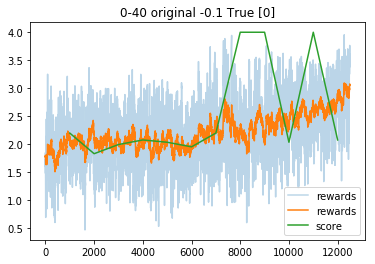


Depth 0: depth_start=0 depth_end=40 agent_type=original, step_reward=0 continuous_learning=True - finished after 10K steps.



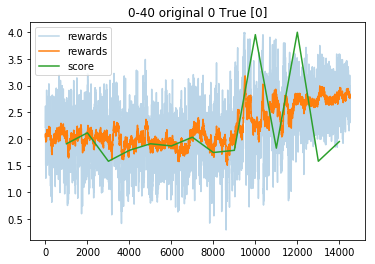

In [ ]:
# argments are 
# depth_start, depth_end, agent_type, step_reward, continuous_learning)

jobs = []

for continuous_learning in [True, False]:
    for originalAgent in [True, False]:
        for step_reward in [0, -0.1]:
            for agent_type in ['original', 'passthru']:
                jobs.append((0, 40, agent_type, step_reward, continuous_learning))

print("Found {} jobs.".format(len(jobs)))

# set the number of threads here, usually 1 per CPU core is best.
print("Starting job list.")
pool = Pool(2)
pool.starmap(generateResults, jobs)
print("done.")
    

Other experiments
* random maze length?
* should really run these 10 times
* would be good to do experience replay
* something more td like would be a good idea